In [ ]:
#@title Default title text
from google.colab import drive

drive.mount('/content/gdrive/')
# !~
# drive.flush_and_unmount()

# %cd  /content/gdrive/MyDrive/MastersD/RTSD_dataset+/rtsd-r3
# !pwd

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# !gdown --id '1eKNfEuNQadRW1H4NOoMw5sdnyHV14ze0'

In [ ]:
# !unzip rtsd-r3.zip

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn
import seaborn as sns
import pandas as pd
import os
import pathlib
import shutil
import cv2
import PIL

TEXT_COLOR = 'black'

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
PROJECT_ROOT = pathlib.Path('rtsd-r3') #pathlib.Path(os.path.join(os.curdir, os.pardir))
ROOT_DIR = PROJECT_ROOT / 'data'
train_dir_source = ROOT_DIR / 'train'
train_dir = ROOT_DIR / 'train'

In [ ]:
gt_train = pd.read_csv(ROOT_DIR / 'gt_train.csv')
numbers_to_classes = pd.read_csv(ROOT_DIR / 'numbers_to_classes.csv')

gt_train = pd.merge(gt_train, numbers_to_classes, on='class_number', how='left', validate='many_to_one', copy=False)
gt_train.drop(['class_number'], inplace=True, axis=1)
gt_train['IsPresent'] = pd.Series([1 for x in range(len(gt_train.index))])

del numbers_to_classes

,filename,sign_class,IsPresent
0,000000.png,2_1,1
1,000001.png,2_1,1
2,000002.png,2_1,1
3,000003.png,2_1,1
4,000004.png,1_23,1
...,...,...,...
70682,070682.png,1_23,1
70683,070683.png,1_23,1
70684,070684.png,1_23,1
70685,070685.png,1_23,1


{"5_19_1":19913,"2_1":8620,"5_16":3751,"5_15_2":3544,"3_27":2409,"1_23":2320,"5_20":1841,"3_24_n40":1804,"4_1_1":1673,"1_17":1145,"3_20":1036,"5_5":915,"5_15_1":873,"4_1_4":871,"3_1":868,"4_2_3":828,"1_25":802,"6_4":794,"7_3":790,"5_15_2_2":700,"3_24_n20":696,"4_2_1":693,"6_6":662,"5_15_3":619,"1_22":603,"2_3_2":593,"5_15_5":559,"2_5":512,"2_2":479,"3_4_1":476,"5_6":474,"4_2_2":433,"2_3_3":400,"4_1_2":359,"1_20_2":319,"7_5":312,"1_2":301,"1_11_1":298,"3_28":294,"5_14":251,"1_11":249,"1_16":235,"3_18":219,"1_1":198,"3_24_n50":193,"2_3":191,"3_18_2":169,"6_3_1":156,"5_15_7":152,"3_24_n5":149,"4_3":149,"5_7_2":141,"4_1_5":139,"4_1_2_1":135,"3_24_n30":131,"7_2":129,"1_12_2":128,"1_15":126,"3_13_r4.5":124,"1_8":120,"4_1_2_2":119,"5_7_1":119,"7_11":111,"3_24_n80":111,"3_2":110,"7_4":110,"7_7":101,"1_21":93,"5_3":91,"3_24_n60":87,"5_11":85,"7_12":84,"2_6":83,"1_33":82,"6_7":80,"3_24_n70":80,"1_12":79,"1_20_3":76,"1_5":72,"4_1_6":68,"6_2_n50":59,"3_32":54,"4_1_3":51,"5_21":51,"1_20":51,"7_6":5

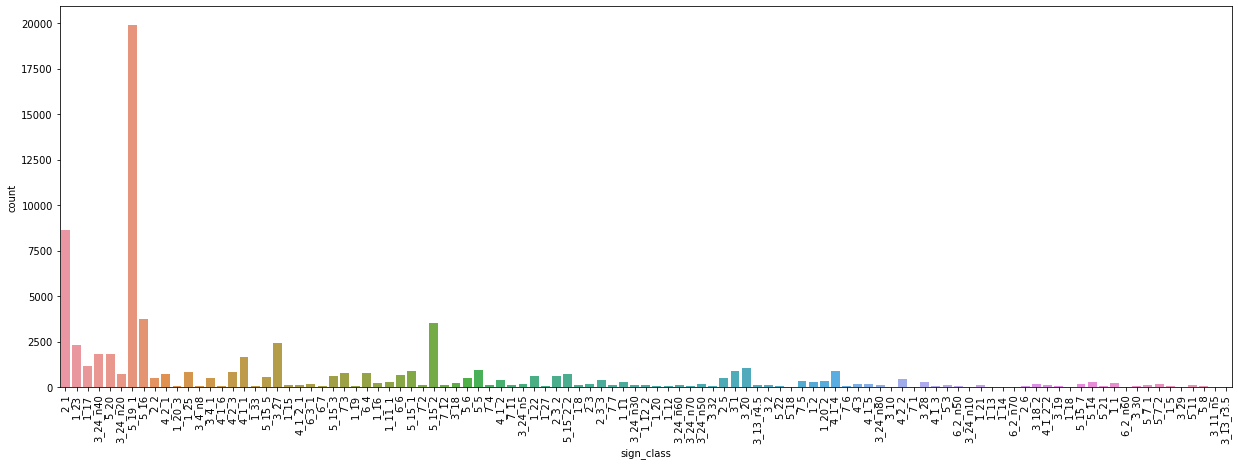

In [ ]:
display(gt_train)
print(gt_train['sign_class'].value_counts().to_json())
_, ax = plt.subplots(figsize=(21, 7))
plt.xticks(rotation=90)
sns.countplot(x='sign_class', data=gt_train, ax=ax);

In [ ]:
EXTRACT_BIG = True
EXTRACT_SPECIFIC_CLASSES = True

if EXTRACT_SPECIFIC_CLASSES == False:
    CLASSES = gt_train['sign_class'].values
    print("[!] Assume classification for all of available classes")
    
else:
    CLASSES = [
        '1_1', '1_6', '1_8', '1_22', '1_31', '1_33', '2_1', '2_2', 
        # ~2_3_1
        '2_3', \
        # /~2_3_1
        '2_4', '2_5', '3_1', 
        # ~3_18_1
        '3_18', 
        # /~3_18_1
        '3_20', '3_21', '3_22', '3_23', \
        # all speed limits
        '3_24_n10', '3_24_n20', '3_24_n30', '3_24_n40', '3_24_n50', '3_24_n60', \
        '3_24_n70', '3_24_n80', '3_24_n90', '3_24_n100', '3_24_n110', '3_24_n120', '3_24_n130', \
        # /all speed limits
        '3_25', '3_27', '3_28', '3_31', '4_1_1', '4_3', '5_5', '5_6', '5_16', 
        '5_19_1',  
        #'5_19_2', \ ~ '5_19_1'
        '5_20', '6_3_2', '6_4', '7_3', '7_4'
    ]
    print("[+] Classification for all of those classes:\n", CLASSES)

def printProgressEnum(index, length, label=None):
    print('\r{}Progress: {}/{} ({:.2f}%)'.
                  format(label if label != None else '', index + 1, length, 100 * (index + 1) / length), flush=True, end='')

def getPictureSignClass(filename=None, path=None, index=None):
    if index:
        return gt_train.iloc[index]['sign_class']
    if path:
        return gt_train[gt_train['filename']==str(path).split(sep='\\')[-1]]['sign_class'].values[0]
    else:
        if filename:
            return gt_train[gt_train['filename']==filename]['sign_class'].values[0]
        else:
            assert False, 'wrong arg'

if EXTRACT_BIG == True:
 
    included_clases = set()
    
    gt_train_size = len(gt_train.index)
    
    for index, row in gt_train.iterrows():

        full_path_to_image = train_dir_source / row['filename']
        
        class_for_current_image = row['sign_class']
                
        if class_for_current_image in CLASSES:
          included_clases.add(class_for_current_image)
          # shutil.copy2(full_path_to_image, train_dir)
        else:
          gt_train.loc[index, 'IsPresent'] = 0
          # print('\n[!]', class_for_current_image, 'is not CLASSES')

        
        if (index % 100 == 0) or (index + 1 == gt_train_size):
            printProgressEnum(index, gt_train_size)
    
    not_included_signs = set(CLASSES) - included_clases
    if not_included_signs:
        print('\n[!] These signs were not included: \n', not_included_signs)

[+] Classification for all of those classes:
 ['1_1', '1_6', '1_8', '1_22', '1_31', '1_33', '2_1', '2_2', '2_3', '2_4', '2_5', '3_1', '3_18', '3_20', '3_21', '3_22', '3_23', '3_24_n10', '3_24_n20', '3_24_n30', '3_24_n40', '3_24_n50', '3_24_n60', '3_24_n70', '3_24_n80', '3_24_n90', '3_24_n100', '3_24_n110', '3_24_n120', '3_24_n130', '3_25', '3_27', '3_28', '3_31', '4_1_1', '4_3', '5_5', '5_6', '5_16', '5_19_1', '5_20', '6_3_2', '6_4', '7_3', '7_4']
Progress: 70687/70687 (100.00%)
[!] These signs were not included: 
 {'3_25', '3_24_n130', '1_6', '3_21', '1_31', '2_4', '3_24_n100', '3_22', '3_24_n110', '3_24_n120', '3_24_n90', '3_23', '3_31', '6_3_2'}


In [ ]:
print(gt_train.loc[gt_train['IsPresent'] == 1]['sign_class'].value_counts())
print(np.mean(gt_train.loc[gt_train['IsPresent'] == 1]['sign_class'].value_counts()))

5_19_1      19913
2_1          8620
5_16         3751
3_27         2409
5_20         1841
3_24_n40     1804
4_1_1        1673
3_20         1036
5_5           915
3_1           868
6_4           794
7_3           790
3_24_n20      696
1_22          603
2_5           512
2_2           479
5_6           474
3_28          294
3_18          219
1_1           198
3_24_n50      193
2_3           191
4_3           149
3_24_n30      131
1_8           120
3_24_n80      111
7_4           110
3_24_n60       87
1_33           82
3_24_n70       80
3_24_n10        9
Name: sign_class, dtype: int64
1585.5483870967741


In [ ]:
MODEL_CLASSES = sorted(list(included_clases))
MODEL_CLASSES

from sklearn import preprocessing
MODEL_LABEL_ENCODER = preprocessing.LabelEncoder()
MODEL_CLASSES_TARGETS = MODEL_LABEL_ENCODER.fit_transform(MODEL_CLASSES)

MODEL_CLASS_MAP = dict(zip(MODEL_CLASSES, MODEL_CLASSES_TARGETS))
MODEL_CLASS_MAP

{'1_1': 0,
 '1_22': 1,
 '1_33': 2,
 '1_8': 3,
 '2_1': 4,
 '2_2': 5,
 '2_3': 6,
 '2_5': 7,
 '3_1': 8,
 '3_18': 9,
 '3_20': 10,
 '3_24_n10': 11,
 '3_24_n20': 12,
 '3_24_n30': 13,
 '3_24_n40': 14,
 '3_24_n50': 15,
 '3_24_n60': 16,
 '3_24_n70': 17,
 '3_24_n80': 18,
 '3_27': 19,
 '3_28': 20,
 '4_1_1': 21,
 '4_3': 22,
 '5_16': 23,
 '5_19_1': 24,
 '5_20': 25,
 '5_5': 26,
 '5_6': 27,
 '6_4': 28,
 '7_3': 29,
 '7_4': 30}

In [ ]:
def getPictureSignClass(filename=None, path=None, index=None):
    if index:
        return gt_train.iloc[index]['sign_class']
    if path:
      return gt_train[gt_train['filename']==pathlib.Path(path).parts[-1]]['sign_class'].values[0]
    else:
        if filename:
            return gt_train[gt_train['filename']==filename]['sign_class'].values[0]
        else:
            assert False, 'wrong arg'

def getRandomPictureFromTrain():
    # instance = gt_train.sample(1)   # fix me or kill me
    while(1):
        instance = gt_train.sample(axis=0)
        # print(instance['IsPresent'].values)
        if instance['IsPresent'].values == 1:
            instance = instance['filename'].values[0]
            break
        
    # print('!', instance)
    path = pathlib.Path(train_dir / instance)
    # print(path)
    return path, getPictureSignClass(path=path)

def showPictureAndClass(path=None, gt_train_index=None):
    if path != None:
        pass
    else:
        if gt_train_index == None:
            assert False, 'cannot identify picture'
        else:
            path = train_dir / gt_train.iloc[gt_train_index]['filename']
    
    sign_class = str(getPictureSignClass(path=path))
    
    fig = plt.figure(figsize=(4, 4))
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.title(f'Label: {sign_class}')
    plt.show()           

rtsd-r3/data/train/016355.png 2_1


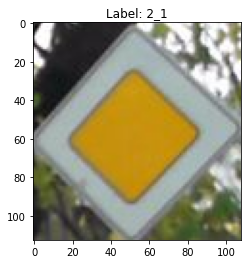

2_1


In [ ]:
path, class_ = getRandomPictureFromTrain()
print(path, class_)
showPictureAndClass(path)
print(getPictureSignClass(path=path))

In [ ]:
class SignDataset(torch.utils.data.Dataset):
    def __init__(self, df, dir):
        self.df = df[df['IsPresent'] == 1]
        self.dir = dir
    def __len__(self):
        return len(self.df.index)
    
    def __getitem__(self, index):
        label = self.df.iloc[index]['sign_class']
        path = self.dir / self.df.iloc[index]['filename']
        # print(path)
        img = cv2.imread(str(path))
        img = cv2.resize(img, (160, 160))
        # print(img)
        img_tnsr = torch.Tensor.permute(torch.Tensor(img), [2, 0, 1]).div(255)
        # print(label)
        encoded_label = MODEL_CLASS_MAP[label]
        # print(encoded_label)
        return img_tnsr, encoded_label

In [ ]:
batch_size_ = 512
train_loader = torch.utils.data.DataLoader(
         SignDataset(gt_train, train_dir),
        batch_size=batch_size_,
        pin_memory=True,
        shuffle=True,
        num_workers=2,
    )
# next(iter(train_loader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torchvision import models, transforms as transforms
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, len(MODEL_CLASSES))
model.to(device)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(244),
        #transforms.RandomResizedCrop(input_size),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(244),
        #transforms.Resize(input_size),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
def train_epoch(model, loader, loss_op, optim):
    loss_ = []
    torch.set_grad_enabled(True)
    
    # Таким образом переводим модель в режим обучения
    # В этом режиме вычисляются градиенты, нужные для обучения
    model.train()
    
    for batch_idx, (imgs_batch, labels_batch) in enumerate(loader):
        # print(imgs_batch.shape)
        imgs_batch = imgs_batch.to(device)
        # print(labels_batch)
        labels_batch = labels_batch.to(device)

        pred = model(imgs_batch)

        loss = loss_op(pred, labels_batch)
        # Сохраним в историю эпохи
        l_ = loss.item()
        loss_.append(l_)
        # model.addValidHistoryAcc(l_)
        # optim.zero_grad()
        for param in model.parameters(): # https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
            param.grad = None
        loss.backward()
        optim.step()
        
        if batch_idx % 20 == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.2f}%)]'.
                  format(epoch, batch_idx * len(imgs_batch), len(loader.dataset),
                 100 * batch_idx * len(imgs_batch) / len(loader.dataset)), flush=True, end='')
        
    print('\rTrain Epoch: {} [{}/{} (100%)]     \n'.
                  format(epoch, len(loader.dataset), len(loader.dataset)), flush=True, end='')
    
    return np.mean(loss_)


from sklearn.metrics import accuracy_score

def evaluate_batch_accuracy(y_pred, y_true):
    '''
    Оценка точности предсказания (accuracy)

    y_pred:
        батч сырых степеней уверенности, размер (N, K)
    y_true:
        вектор истинных значений, размер (N)
    '''
    y_pred = y_pred.detach().numpy()
    y_true = y_true.detach().numpy()
    # print(y_true)
    # print(y_pred)
    accuracy = 0
    for i in range(len(y_true)):
        index_max = max(range(len(y_pred[i, :])), key=y_pred[i].__getitem__)
        # print(index_max)
        if (index_max == y_true[i]):
            accuracy += 1
    accuracy /= len(y_pred)
    return accuracy

def valid_epoch(model, loader, loss):
    acc_ = []
    torch.set_grad_enabled(False)
    # Таким образом переводим модель в режим исполнения (inference)
    # В этом режиме отключены градиенты, он быстрее, 
    #   но в нём нельзя обучать модель
    model.eval()
    for batch_idx, (imgs_batch, labels_batch) in enumerate(loader):
        imgs_batch = imgs_batch.to(device)
        #print(labels_batch)
        labels_batch = labels_batch.to(device)
        
        pred = model(imgs_batch)
        
        local_acc = evaluate_batch_accuracy(pred.cpu(), labels_batch.cpu())
        acc_.append(local_acc)
        
        # model.addValidHistoryAcc(local_acc)
        
        if batch_idx % 20 == 0:
            print('\rValid Epoch: {} [{}/{} ({:.2f}%)]'.
                  format(epoch, batch_idx * len(imgs_batch), len(loader.dataset),
                 100 * batch_idx * len(imgs_batch) / len(loader.dataset)), flush=True, end='')
        
    print('\rValid Epoch: {} [{}/{} (100%)]     \n'.
                  format(epoch, len(loader.dataset), len(loader.dataset)), flush=True, end='')
    
    return np.mean(acc_)

In [ ]:
config = {
    'lr': 0.0001,
    'epochs': 150,
}

loss_op = nn.CrossEntropyLoss().cuda()
optim = torch.optim.Adadelta(model.parameters(), lr=config['lr'])

if os.path.isfile('resnet18_rtsd_test'):
    model.load_state_dict(torch.load('resnet18_rtsd_test'))
    print('[+] Model restored from save file!')

history = {
    'train_loss': [],
    'valid_acc': []
}

import shutil
from datetime import datetime
model.to(device)

for epoch in range(config['epochs']):
    

    history['train_loss'].append(train_epoch(model, train_loader, loss_op, optim))

    print(f'Epoch {epoch}:')
    print('  Train loss:', history['train_loss'][-1])

    history['valid_acc'].append(valid_epoch(model, train_loader, loss_op))
    # model.incIter()
    print('  Valid acc:', history['valid_acc'][-1])
    
    now = datetime.now()
    model_save_name = 'resnet18_rtsd_test_{}_loss{:.4f}_acc_{:.4f}'.format(now.strftime("%m.%d_%H.%M"),
                                                                  history['train_loss'][-1],
                                                                  history['valid_acc'][-1],
                                                         )

    torch.save(model.state_dict(), model_save_name)
    shutil.copy2(model_save_name, '/content/gdrive/MyDrive/MastersD/RTSD_dataset+/rtsd-r3/')

    torch.save(model.state_dict(), 'resnet18_rtsd_test')
    shutil.copy2('resnet18_rtsd_test', '/content/gdrive/MyDrive/MastersD/RTSD_dataset+/rtsd-r3/')
    

print(history)

[+] Model restored from save file!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 0 [49152/49152 (100%)]     
Epoch 0:
  Train loss: 0.4431831904997428
Valid Epoch: 0 [49152/49152 (100%)]     
  Valid acc: 0.9030965169270834
Train Epoch: 1 [49152/49152 (100%)]     
Epoch 1:
  Train loss: 0.4400562938923637
Valid Epoch: 1 [49152/49152 (100%)]     
  Valid acc: 0.9038899739583334
Train Epoch: 2 [49152/49152 (100%)]     
Epoch 2:
  Train loss: 0.4360350891947746
Valid Epoch: 2 [49152/49152 (100%)]     
  Valid acc: 0.9045206705729166
Train Epoch: 3 [49152/49152 (100%)]     
Epoch 3:
  Train loss: 0.4331373531992237
Valid Epoch: 3 [49152/49152 (100%)]     
  Valid acc: 0.9049886067708334
Train Epoch: 4 [49152/49152 (100%)]     
Epoch 4:
  Train loss: 0.43000386841595173
Valid Epoch: 4 [49152/49152 (100%)]     
  Valid acc: 0.9053751627604166
Train Epoch: 5 [49152/49152 (100%)]     
Epoch 5:
  Train loss: 0.4262792070706685
Valid Epoch: 5 [49152/49152 (100%)]     
  Valid acc: 0.9060872395833334
Train Epoch: 6 [40960/49152 (83.33%)]